<a href="https://colab.research.google.com/github/SNEHA-67/comp215/blob/main/labs/lab04-more_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 4
----------------
#### Name(s):Sneha & Manmeet Sharma
#### Date:29-01-2025

By the end of this lab you should be able to:
  * use composition and inheritance in a `class` to categorize related information


During this lab, you will be introduced to the following:
  * something, something



## Near Earth Objects (with more classes)

We'll continue working with Near Earth Object data using NASA's API: https://api.nasa.gov/.  In Lab 3 we defined an Asteroid class that contained a simple data structure.  In this lab, we will be Here's a brief review from Lab 2 on how to use the API.  

In [2]:
# import necessary modules
import datetime, json, requests
from pprint import pprint

### Review: make an API query

Here's a query that gets the record for a single NEO that recently passed by.

In [3]:
#API_KEY = 'DEMO_KEY'  # substitute your API key here
API_KEY = 'QMU73gySBTeUk6FVRje8eMwNOFfI1FZOwRtlf0Xo'

def get_neos(start_date):
    """ Return a list of NEO for the week starting at start_date """
    url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={start_date}&api_key={API_KEY}'
    # Fetch last week's NEO feed
    response = requests.request("GET", url, headers={}, data={})
    data = json.loads(response.text)
    #pprint(data)
    print(f'{data["element_count"]} Near Earth Objects found for week of {start_date}')
    return [neo for dated_records in data['near_earth_objects'].values() for neo in dated_records ]

def get_neo(id):
    """ Return a NEO record for the given id """
    url = f'https://api.nasa.gov/neo/rest/v1/neo/{id}?api_key={API_KEY}'
    response = requests.request("GET", url, headers={}, data={})
    return json.loads(response.text)

week_start = '2023-01-15'
neos = get_neos(week_start)
assert len(neos) > 0, f'Oh oh!  No NEOs found for {week_start}'
neo = get_neo(neos[-1]['id'])  # get the very latest NEO
print(f"Record for NEO ID {neos[-1]['id']} is:")
pprint(neo)

117 Near Earth Objects found for week of 2023-01-15
Record for NEO ID 54339874 is:
{'absolute_magnitude_h': 24.86,
 'close_approach_data': [{'close_approach_date': '1949-07-04',
                          'close_approach_date_full': '1949-Jul-04 22:19',
                          'epoch_date_close_approach': -646710060000,
                          'miss_distance': {'astronomical': '0.419726307',
                                            'kilometers': '62790161.51016609',
                                            'lunar': '163.273533423',
                                            'miles': '39015997.166588442'},
                          'orbiting_body': 'Earth',
                          'relative_velocity': {'kilometers_per_hour': '73509.6739172087',
                                                'kilometers_per_second': '20.4193538659',
                                                'miles_per_hour': '45676.0526626122'}},
                         {'close_approach_date': '1950-0

## Exercise 1: Define a CloseApproach class

Each NEO record comes with a list of `close_approach_data`, where each record in this list represents a single “close approach” to another orbiting body.
1. Develop a class named `CloseApproach` to represent a single close approach record.  State variables are

        neo (refrence to related NEO object)
        orbiting body (str)
        approach date (datetime object!)
        miss distance (float - choose units, document it, and be consistent!)
        relative velocity (ditto)
  
2. Define a "Factory" class method to construct a `CloseApproach` object from one close approach data record (a dictionary object). This method takes a `neo` object as input for the NEO to which the close approach data belongs. Remember to parse the date/time string into a datetime object.

In [12]:
# Ex. 1 your code here
# Define the Asteroid and CloseApproach classes
class CloseApproach:
    """ Represents a single close approach record of a Near Earth Object (NEO). """
    def __init__(self, neo, orbiting_body, approach_date, miss_distance, relative_velocity):
        self.neo = neo
        self.orbiting_body = orbiting_body
        self.approach_date = approach_date
        self.miss_distance = miss_distance
        self.relative_velocity = relative_velocity

    @classmethod
    def from_dict(cls, neo, close_approach_data):
        """ Factory method to create a CloseApproach object from a dictionary. """
        approach_date = datetime.strptime(
            close_approach_data['close_approach_date_full'],
            '%Y-%b-%d %H:%M'
        )
        miss_distance = float(close_approach_data['miss_distance']['kilometers'])
        relative_velocity = float(close_approach_data['relative_velocity']['kilometers_per_second'])
        return cls(
            neo=neo,
            orbiting_body=close_approach_data['orbiting_body'],
            approach_date=approach_date,
            miss_distance=miss_distance,
            relative_velocity=relative_velocity
        )

    def __repr__(self):
        return (f"CloseApproach(neo={self.neo}, orbiting_body='{self.orbiting_body}', "
                f"approach_date={self.approach_date}, miss_distance={self.miss_distance:.2f} km, "
                f"relative_velocity={self.relative_velocity:.2f} km/s)")


## Exercise 2: Add list of CloseApproach objects to the Asteroid

Define an `Asteroid` class, like you did in Lab 3, but give the `Asteroid` list of “close approaches”.  This is called *composition* because each Asteroid object will be *composed* of CloseApproach objects (plus some other things).  There is bit of a catch-22 here because we need the `Asteroid` to construct the `CloseApproach` objects. The first two steps deal with that:

1. Add an instance variable to your Asteroid class with a default value of an empty list:

    ```
    close_approaches:list = []
    ```
      
2. In the Asteroid `from_NEO` factory, use a list comprehension to build the list of `CloseApproach` objects for the Asteroid instance, and then set the instance's `close_approaches` variable before returning it. Setting the value of an object's instance variables from outside the class is generally frowned upon - this is why we make the factory a method of the class itself.

3. Add a method to `Asteroid` to return the `CloseApproach` object for the nearest miss (ie. smallest `missed_distance`):
    ```
    def nearest_miss(self):
        ...
    ```

4. Add a method to the Asteroid class, `closest_earth_approach`, that returns the CloseApproach object that represents the closest approach the Asteroid makes to Earth.
    ```
    def closest_earth_approach(self):
        ...
    ```

Write some test code to demonstrate these new features.

In [14]:
# Ex. 2 your code here
class Asteroid:
    """ Represents an Asteroid object with a list of CloseApproach objects. """
    def __init__(self, id, name, close_approaches=None):
        self.id = id
        self.name = name
        self.close_approaches = close_approaches if close_approaches is not None else []

    @classmethod
    def from_NEO(cls, neo_data):
        """ Factory method to create an Asteroid object from an NEO dictionary. """
        asteroid = cls(
            id=neo_data['id'],
            name=neo_data['name']
        )
        asteroid.close_approaches = [
            CloseApproach.from_dict(asteroid, approach_data)
            for approach_data in neo_data['close_approach_data']
        ]
        return asteroid

    def nearest_miss(self):
        """ Returns the CloseApproach object with the smallest miss distance. """
        if not self.close_approaches:
            return None
        return min(self.close_approaches, key=lambda ca: ca.miss_distance)

    def closest_earth_approach(self):
        """ Returns the CloseApproach object with the smallest miss distance to Earth. """
        if not self.close_approaches:
            return None
        earth_approaches = [
            ca for ca in self.close_approaches if ca.orbiting_body == 'Earth'
        ]
        if not earth_approaches:
            return None
        return min(earth_approaches, key=lambda ca: ca.miss_distance)

    def __repr__(self):
        return f"Asteroid(id={self.id}, name='{self.name}', close_approaches={len(self.close_approaches)})"


## Exercise 3: Plot the Closest Approaches

Write a function that takes an Asteroid object as a parameter and makes a timeline plot of close approaches.  You may wish to use the `matplotlib.pyplot` `plot` object.  Here is an example of a timeline plot for the asteroid with neo id '54339874'

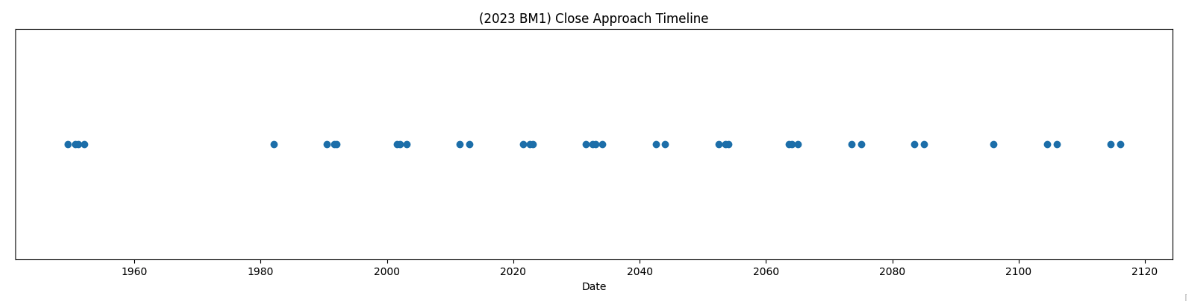

117 Near Earth Objects found for week of 2023-01-15


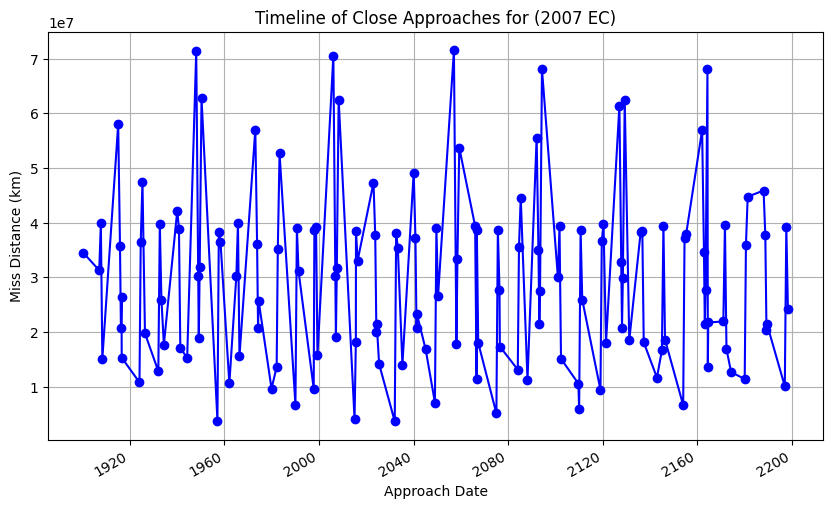

In [15]:
# Function to plot close approaches
def plot_close_approaches(asteroid):
    """
    Plots a timeline of close approaches for the given Asteroid object.

    Args:
        asteroid (Asteroid): The Asteroid object to plot.
    """
    if not asteroid.close_approaches:
        print("No close approaches found for this asteroid.")
        return

    # Extract data for plotting
    dates = [ca.approach_date for ca in asteroid.close_approaches]
    miss_distances = [ca.miss_distance for ca in asteroid.close_approaches]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(dates, miss_distances, marker='o', linestyle='-', color='b')

    # Add labels and title
    plt.title(f'Timeline of Close Approaches for {asteroid.name}')
    plt.xlabel('Approach Date')
    plt.ylabel('Miss Distance (km)')
    plt.grid(True)

    # Format the x-axis to show dates nicely
    plt.gcf().autofmt_xdate()

    # Show the plot
    plt.show()

# Fetch data from the API
week_start = '2023-01-15'
neos = get_neos(week_start)

# Check if NEOs were found
if not neos:
    print(f"No NEOs found for the week of {week_start}.")
else:
    # Get the first NEO from the list
    first_neo_id = neos[0]['id']
    neo_data = get_neo(first_neo_id)

    # Create an Asteroid object
    asteroid = Asteroid.from_NEO(neo_data)

    # Plot the close approaches
    plot_close_approaches(asteroid)

## Challenge - Take your skills to the next level...

 With these data structures in place, we can now start answering all kinds of interesting questions about a single Asteroid or a set of Asteroids.  
Here’s a couple ideas to try:



* write a **function** named `most_dangerous_approach`, that takes a date range and returns a single “potentially hazardous” Asteroid object that makes the closest approach to Earth in within that range.  Your algorithm will ultimately need to:
    * grab the list of NEO’s for the given date range;
    * use a list comprehension to build the list of Asteroid objects for the NEO’s returned
    * use a list comprehension to filter  potentially hazardous Asteroids only;
    * use a list comprehension to map each Asteroid to its  closest_earth_approach
    * apply Python’s min function to identify the Asteroid with the closest_earth_approach

You may want to decompose some of these steps into smaller functions.
* add a method to the Asteroid class, estimated_mass, that computes an estimate of the Asteroid’s mass based on its diameter.  This is a model – state your assumptions.
* add a method to the CloseApproach class, impact_force,  that estimates the force of impact if the Asteroid hit the orbiting object.  Again, this is a model, state your assumptions.

In [20]:
# Class for Close Approach details
class CloseApproach:
    """Represents a single close approach record of a Near Earth Object (NEO)."""
    def __init__(self, neo, orbiting_body, approach_date, miss_distance, relative_velocity):
        self.neo = neo
        self.orbiting_body = orbiting_body
        self.approach_date = approach_date
        self.miss_distance = miss_distance
        self.relative_velocity = relative_velocity

    @classmethod
    def from_dict(cls, neo, close_approach_data):
        """Factory method to create a CloseApproach object from a dictionary."""
        approach_date = datetime.datetime.strptime(
            close_approach_data['close_approach_date_full'],
            '%Y-%b-%d %H:%M'
        )
        miss_distance = float(close_approach_data['miss_distance']['kilometers'])
        relative_velocity = float(close_approach_data['relative_velocity']['kilometers_per_second'])
        return cls(
            neo=neo,
            orbiting_body=close_approach_data['orbiting_body'],
            approach_date=approach_date,
            miss_distance=miss_distance,
            relative_velocity=relative_velocity
        )

    def __repr__(self):
        return (f"CloseApproach(neo={self.neo.name}, orbiting_body='{self.orbiting_body}', "
                f"approach_date={self.approach_date}, miss_distance={self.miss_distance:.2f} km, "
                f"relative_velocity={self.relative_velocity:.2f} km/s)")

# Class for Asteroid details
class Asteroid:
    """Represents an Asteroid object with a list of CloseApproach objects."""
    def __init__(self, id, name, estimated_diameter, close_approaches=None, is_hazardous=False):
        self.id = id
        self.name = name
        self.estimated_diameter = estimated_diameter
        self.close_approaches = close_approaches if close_approaches is not None else []
        self.is_hazardous = is_hazardous  # Add hazardous attribute

    @classmethod
    def from_NEO(cls, neo_data):
        """Factory method to create an Asteroid object from an NEO dictionary."""
        estimated_diameter = neo_data['estimated_diameter']['kilometers']
        # Determine if the asteroid is potentially hazardous
        is_hazardous = neo_data.get('is_potentially_hazardous_asteroid', False)
        asteroid = cls(
            id=neo_data['id'],
            name=neo_data['name'],
            estimated_diameter=estimated_diameter,
            is_hazardous=is_hazardous
        )
        asteroid.close_approaches = [
            CloseApproach.from_dict(asteroid, approach_data)
            for approach_data in neo_data['close_approach_data']
        ]
        return asteroid

    def closest_earth_approach(self):
        """Returns the CloseApproach object with the smallest miss distance to Earth."""
        earth_approaches = [
            ca for ca in self.close_approaches if ca.orbiting_body == 'Earth'
        ]
        return min(earth_approaches, key=lambda ca: ca.miss_distance) if earth_approaches else None

    def __repr__(self):
        return f"Asteroid(id={self.id}, name='{self.name}', close_approaches={len(self.close_approaches)}, is_hazardous={self.is_hazardous})"

def most_dangerous_approach(start_date, end_date):
    """Returns a potentially hazardous Asteroid object that makes the closest approach to Earth within the given date range."""
    # Fetch NEOs for the given date range
    neos = get_neos(start_date, end_date)

    # Create a list of Asteroid objects from the NEOs returned
    asteroids = [Asteroid.from_NEO(neo) for neo in neos]

    # Filter the list for potentially hazardous Asteroids
    hazardous_neos = [neo for neo in asteroids if neo.is_hazardous]

    # If there are no hazardous asteroids, return None
    if not hazardous_neos:
        return None

    # Map each hazardous Asteroid to its closest approach
    closest_approaches = [(neo, neo.closest_earth_approach()) for neo in hazardous_neos]

    # Filter out asteroids with no close approaches
    closest_approaches = [(neo, approach) for neo, approach in closest_approaches if approach is not None]

    # Use min function to identify the Asteroid with the closest approach
    if closest_approaches:
        most_dangerous_neo = min(closest_approaches, key=lambda x: x[1].miss_distance)[0]
        return most_dangerous_neo

    return None


# Fetch data and test the implementation
week_start = '2023-01-15'
week_end = '2023-01-22'

# Fetch NEOs
neos = get_neos(week_start, week_end)

if neos:
    first_neo_id = neos[0]['id']
    neo_data = get_neo(first_neo_id)

    # Create an Asteroid object
    asteroid = Asteroid.from_NEO(neo_data)

    # Find the most dangerous approach
    most_dangerous = most_dangerous_approach(week_start, week_end)

    if most_dangerous:
        print(f"The most dangerous asteroid between {week_start} and {week_end} is {most_dangerous.name}")
        print(f"Closest Earth approach: {most_dangerous.closest_earth_approach()}")
    else:
        print("No hazardous asteroids found in the given date range.")


117 Near Earth Objects found for the period 2023-01-15 to 2023-01-22
117 Near Earth Objects found for the period 2023-01-15 to 2023-01-22
The most dangerous asteroid between 2023-01-15 and 2023-01-22 is (2022 WS4)
Closest Earth approach: CloseApproach(neo=(2022 WS4), orbiting_body='Earth', approach_date=2023-01-20 09:42:00, miss_distance=11936428.02 km, relative_velocity=10.91 km/s)
